# Problem Statement:
The objective of this case study is to predict the class of flower using computer vision techniques such as CNN and ResNet

In [1]:
# Importing all the neccesary dependencies

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

###  Downloading Dataset
We are downloading dataset from mentaioned path given in the code below. We are using tf.keras.utils.get_file to download the data in keras cache directory using pathlib module

In [2]:
import pathlib

dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir=tf.keras.utils.get_file('flower_photos',origin=dataset_url,untar=True)
data_dir=pathlib.Path(data_dir)

228813984/228813984 [==============================] - 2s 0us/step


### Exploring dataset
Now since we have downloaded the dataset, we will check here how many total images that we have and we will be viewing the images of some flowers such as rose and tulips as part of this section and we will be using PIL library to process the image and also we will be defining the batch_size, height and width of the image

In [3]:
# Getting image count

image_count=len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


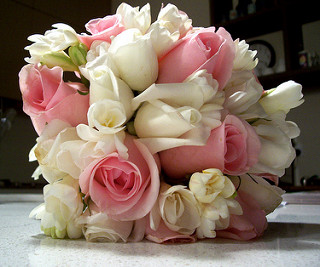

In [5]:
# let's explore our first image

roses=list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

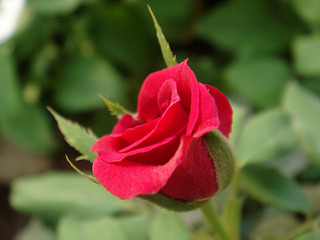

In [10]:
PIL.Image.open(str(roses[9]))

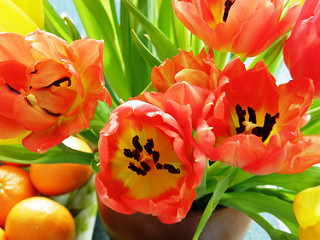

In [11]:
# Checking for tulips

tulips=list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

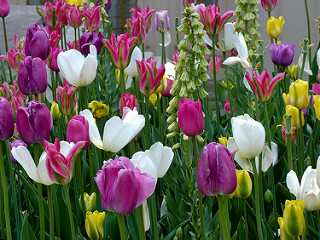

In [13]:
PIL.Image.open(str(tulips[6]))

In [14]:
# Defining batch_size, height and width of image

batch_size=32
image_height=180
image_width=180

In [15]:
# Splitting into train and validation dataset

train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(image_height,image_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
# Creating validation subset

val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=456,
    image_size=(image_height,image_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Checking class names of flowers
Here we are checking what are the different classes that we have in flower dataset. We have total 5 classes such as daisy, dandelion, roses, sunflowers,tulips

In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data
Here we will be visualizing our data using matplotlib library. We will be checking for diifferent classes and images of flowers that we have in our dataset

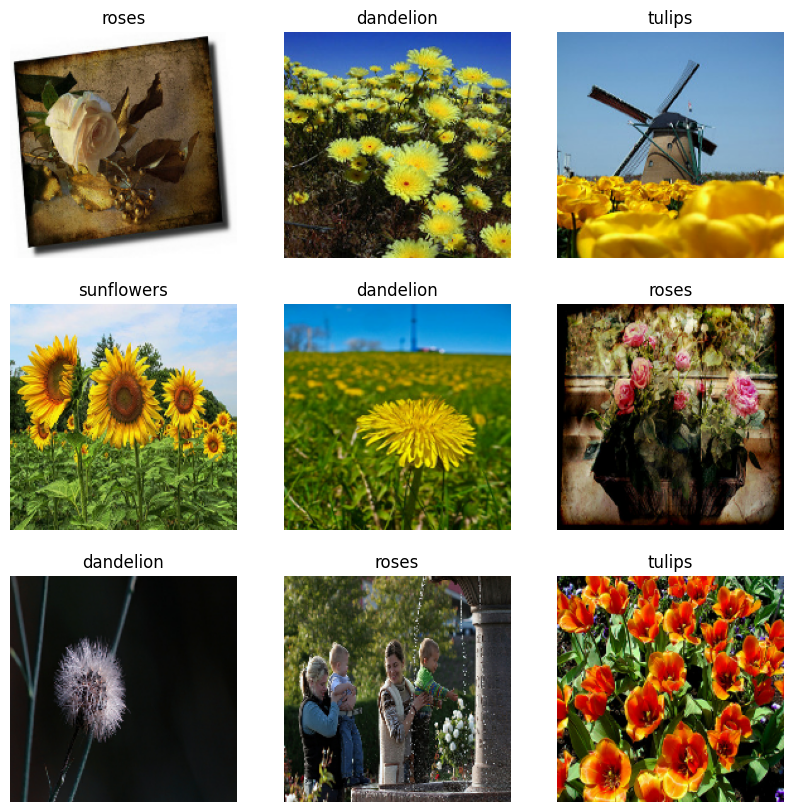

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

### Checking size of image_batch and labels_batch
The image_batch is a tensor of the shape (32,180,180,3). The batch 32 images of shape (180x180x3). The last dimension shows the colors channels RGB. The label_batch is a tensor of the shape (32), corresponding labels to the 32 images  

In [19]:
for image_batch,labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


### Configuring dataset for performance
Dataset cache() keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model

In [20]:
# To configure dataset for performance

AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Standardization of the data
Standardize values to be in the [0,1]range by using a Rescaling layer. The RGB channel values are in the [0,255]range. This is not ideal for a neural network; in general you should seek to make your input values to be small, standardize values to be in the [0,1]range by using a Rescaling layer  

In [21]:
normalization_layer=layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds=train_ds.map(lambda x, y:(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in '[0,1]'
print(np.min(first_image), np.max(first_image))

0.0 0.9961222


### Building CNN Model
The model has three convolution blocks with a max pooling layer in each of them. There is a fully connected layer with 128 units on top of it that is activated by ReLu activation function and then compiling the model and checking for model summary which gives number of trainable and non-trainable parameters and total parameters

In [ ]:
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam

In [22]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(image_height, image_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [23]:
# Compile the model

model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model using epochs
Here we will be using 10 epochs to train our model and for each of the epochs we will be checking how our model training and validation accuracy is responding and we will be also checking for the loss

In [25]:
# Train the model

epochs=10
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=epochs)

Epoch 1/10
92/92 [==============================] - 137s 1s/step - loss: 1.4338 - accuracy: 0.4295 - val_loss: 1.0657 - val_accuracy: 0.5627
Epoch 2/10
92/92 [==============================] - 135s 1s/step - loss: 0.9774 - accuracy: 0.6175 - val_loss: 1.0934 - val_accuracy: 0.5790
Epoch 3/10
92/92 [==============================] - 128s 1s/step - loss: 0.6821 - accuracy: 0.7476 - val_loss: 1.0195 - val_accuracy: 0.5967
Epoch 4/10
92/92 [==============================] - 130s 1s/step - loss: 0.3578 - accuracy: 0.8764 - val_loss: 1.0566 - val_accuracy: 0.6172
Epoch 5/10
92/92 [==============================] - 128s 1s/step - loss: 0.1583 - accuracy: 0.9523 - val_loss: 1.5290 - val_accuracy: 0.5954
Epoch 6/10
92/92 [==============================] - 128s 1s/step - loss: 0.1020 - accuracy: 0.9745 - val_loss: 1.7276 - val_accuracy: 0.5831
Epoch 7/10
92/92 [==============================] - 133s 1s/step - loss: 0.0440 - accuracy: 0.9894 - val_loss: 1.7630 - val_accuracy: 0.6117
Epoch 8/10
92

### Plotting graph for comparison of training & validation accuracy
Here we will be using matplotlib library to check for training and validation accuracy and for the comparison between the two

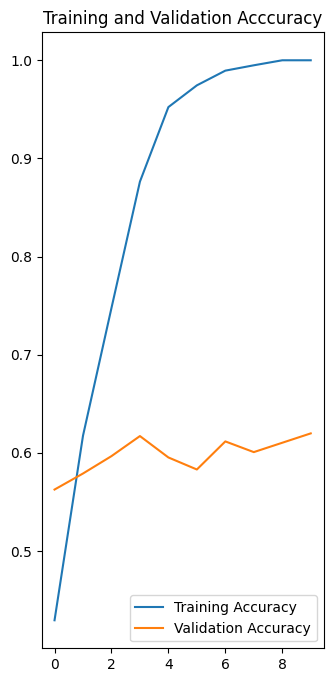

In [26]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs_range=range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Acccuracy')
plt.show()

### CONCLUSION :

### We have done all the necessary steps for building the computer vision CNN model, we get only 62% validation accuracy but training accuracy were 100% , so the model is result of ovetfit so to get generalized model we use anoter model and also we have to improve performance & acuracy we now go ahead with ResNet Model to compare it with CNN model, after chossing best performing model we use it for prediction & deployment purpose. !!